In [1]:
# use dir() to see attributes
# use help() to see an object's methods

In [2]:
import operator
import os
import numpy as np

import pickle
import pandas as pd
import pytz

from qstrader.data.daily_bar_csv import CSVDailyBarDataSource
from qstrader.alpha_model.alpha_model import AlphaModel
from qstrader.alpha_model.fixed_signals import FixedSignalsAlphaModel
from qstrader.signals.buffer import AssetPriceBuffers
from qstrader.asset.equity import Equity
from qstrader.asset.universe.static import StaticUniverse
from qstrader.signals.signal import Signal 
from qstrader.signals.signals_collection import SignalsCollection
from qstrader.data.backtest_data_handler import BacktestDataHandler
from qstrader.statistics.tearsheet import TearsheetStatistics
from qstrader.trading.backtest import BacktestTradingSession

In [3]:
#strategy symbols
strategy_symbols = ['SPY']
strategy_assets = ['EQ:%s' % symbol for symbol in strategy_symbols]
strategy_universe = StaticUniverse(strategy_assets)
    
# data source to load only those provided symbols
csv_dir = os.environ.get('QSTRADER_CSV_DATA_DIR', '.')
data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=strategy_symbols)
data_handler = BacktestDataHandler(strategy_universe, data_sources=[data_source])

Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Adjusting pricing in CSV files...
Adjusting CSV file for symbol 'EQ:SPY'...


In [9]:
class MomentumSignal(Signal):
    """
    Indicator class to calculate lookback-period momentum
    (based on cumulative return of last N periods) for
    a set of prices.
    If the number of available returns is less than the
    lookback parameter the momentum is calculated on
    this subset.
    Parameters
    ----------
    start_dt : `pd.Timestamp`
        The starting datetime (UTC) of the signal.
    universe : `Universe`
        The universe of assets to calculate the signals for.
    lookbacks : `list[int]`
        The number of lookback periods to store prices for.
    """

    def __init__(self, start_dt, universe, lookbacks):
        bumped_lookbacks = [lookback for lookback in lookbacks]
        super().__init__(start_dt, universe, bumped_lookbacks)

    @staticmethod
    def _asset_lookback_key(asset, lookback):
        """
        Create the buffer dictionary lookup key based
        on asset name and lookback period.
        Parameters
        ----------
        asset : `str`
            The asset symbol name.
        lookback : `int`
            The lookback period.
        Returns
        -------
        `str`
            The lookup key.
        """
        return '%s_%s' % (asset, lookback)

    def _cumulative_return(self, asset, lookback):
        """
        Calculate the cumulative returns for the provided
        lookback period ('momentum') based on the price
        buffers for a particular asset.
        Parameters
        ----------
        asset : `str`
            The asset symbol name.
        lookback : `int`
            The lookback period.
        Returns
        -------
        `float`
            The cumulative return ('momentum') for the period.
        """
        series = pd.Series(
            self.buffers.prices[MomentumSignal._asset_lookback_key(asset, lookback)]
        )
        returns = series.pct_change().dropna().to_numpy()

        if len(returns) < 1:
            return 0.0
        else:
            return (np.cumprod(1.0 + np.array(returns)) - 1.0)[-1]

    def __call__(self, asset, lookback):
        """
        Calculate the lookback-period momentum
        for the asset.
        Parameters
        ----------
        asset : `str`
            The asset symbol name.
        lookback : `int`
            The lookback period.
        Returns
        -------
        `float`
            The momentum for the period.
        """
        return self._cumulative_return(asset, lookback)

In [41]:
# I'm unsure if I should call this signals or signal. In the momentum example
# he's using a child class MomentumSignals. I don't need a lookback window,
# so I think I just need to use the parent class

class HiddenMarkovAlphaModel(AlphaModel):
    #keep model static for now, but a look_back parameter could be added to modify the lookback window
    def __init__(self, hmm_model, signals, lookback, universe, data_handler):
        self.hmm_model = hmm_model
        self.signals = signals
        self.lookback = lookback
        self.universe = universe
        self.data_handler = data_handler
    #methods
    # determining the regime is going to have to take time, i just think time
    # as parameters. 
    # time needs to be a parameter so it can look up the price on that day. 
    def determine_regime(
        self, dt
    ):
#             dt : `pd.Timestamp`
#             The datetime for which the prediction
#             should be calculated.
# First we need to select the assets
        asset = self.signals['momentum'].assets[0]
        # then we need to grab the adjust closing returns
        #returns = {
            #asset: self.signals['momentum'](
                #asset, self.lookback
#             ) for asset in assets
#         }
        #fit the model to the returns
        returns = self.signals['momentum'](asset, self.lookback)
        hidden_state = self.hmm_model.predict(np.array([returns]).reshape(1,-1))
        return hidden_state
    
    #generate the investment or sell signal. In this case return weight 1
    #if regime is favorable, or weight 0 if the regime isnt favorable
    def _generate_signals(
        self, dt, weights
    ):
        hidden_state = self.determine_regime(dt)
        asset = self.signals['momentum'].assets[0]
        if hidden_state == 1:
            weights[asset] = 1
        else:
            weights[asset] = 0.0
        return weights

#threw this in there because it errored. 
    def __call__(
        self, dt
    ):
#         """
#         Calculates the signal weights for the top N
#         momentum alpha model, assuming that there is
#         sufficient data to begin calculating momentum
#         on the desired assets.

#         Parameters
#         ----------
#         dt : `pd.Timestamp`
#             The datetime for which the signal weights
#             should be calculated.

#         Returns
#         -------
#         `dict{str: float}`
#             The newly created signal weights dictionary.
#         """
        assets = self.universe.get_assets(dt)
        weights = {asset: 0.0 for asset in assets}

        # Only generate weights if the current time exceeds the
        # momentum lookback period
        if self.signals.warmup >= self.lookback:
            weights = self._generate_signals(dt, weights)
        return weights

#back_test parameters
if __name__ == "__main__":
    # Duration of the backtest
    start_dt = pd.Timestamp('2006-01-02 14:30:00', tz=pytz.UTC)
    end_dt = pd.Timestamp('2022-04-30 23:59:00', tz=pytz.UTC)
    
# load pickle
infile = open('hmm_model_spy.pkl', 'rb')
hmm_model = pickle.load(infile)

#Generate the signals used in the HMM model
# NOTE: lookback must be passed as a list. lookback of [1] + momentum signal just calculates the returns from the previous day
#which is what HMM predicts off of.  
lookback = 3
lookbacks = [lookback]
hmm_return_signal = MomentumSignal(start_dt, strategy_universe, lookbacks=lookbacks)
signals = SignalsCollection({'momentum': hmm_return_signal}, data_handler)

#hidden markov strategy alpha model 
strategy_alpha_model = HiddenMarkovAlphaModel(
    hmm_model, signals, lookback, strategy_universe, data_handler
)


strategy_alpha_model.determine_regime(pd.Timestamp('2022-04-30 23:59:00', tz=pytz.UTC))

In [42]:
strategy_alpha_model.signals['momentum'].assets

['EQ:SPY']

hmm_model.predict(np.array([0.01]).reshape(1,-1))

In [43]:
strategy_alpha_model.signals['momentum']('EQ:SPY', 3)

KeyError: 'EQ:SPY_3'

In [44]:
#back_test parameters
if __name__ == "__main__":
    # Duration of the backtest
    start_dt = pd.Timestamp('2006-01-02 14:30:00', tz=pytz.UTC)
    end_dt = pd.Timestamp('2022-04-30 23:59:00', tz=pytz.UTC)
    
# load pickle
infile = open('hmm_model_spy.pkl', 'rb')
hmm_model = pickle.load(infile)

#Generate the signals used in the HMM model
# NOTE: lookback must be passed as a list. lookback of [1] + momentum signal just calculates the returns from the previous day
#which is what HMM predicts off of.  
lookback = 1
lookbacks = [lookback]
hmm_return_signal = MomentumSignal(start_dt, strategy_universe, lookbacks=lookbacks)
signals = SignalsCollection({'momentum': hmm_return_signal}, data_handler)

#hidden markov strategy alpha model 
strategy_alpha_model = HiddenMarkovAlphaModel(
    hmm_model, signals, lookback, strategy_universe, data_handler
)

#try changing to long/short later
strategy_backtest = BacktestTradingSession(
    start_dt,
    end_dt,
    strategy_universe,
    strategy_alpha_model,
    signals = signals,
    rebalance='end_of_month',
    long_only=True,
    cash_buffer_percentage=0.01,
    data_handler=data_handler
)
strategy_backtest.run()


Initialising simulated broker "Backtest Simulated Broker Account"...
(2006-01-02 14:30:00+00:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2006-01-02 14:30:00+00:00) - subscription: 1000000.00 subscribed to portfolio "000001"
Beginning backtest simulation...
(2006-01-02 14:30:00+00:00) - market_open
(2006-01-02 21:00:00+00:00) - market_close
(2006-01-03 14:30:00+00:00) - market_open
(2006-01-03 21:00:00+00:00) - market_close
(2006-01-04 14:30:00+00:00) - market_open
(2006-01-04 21:00:00+00:00) - market_close
(2006-01-05 14:30:00+00:00) - market_open
(2006-01-05 21:00:00+00:00) - market_close
(2006-01-06 14:30:00+00:00) - market_open
(2006-01-06 21:00:00+00:00) - market_close
(2006-01-09 14:30:00+00:00) - market_open
(2006-01-09 21:00:00+00:00) - market_close
(2006-01-10 14:30:00+00:00) - market_open
(2006-01-10 21:00:00+00:00) - market_close
(2006-01-11 14:30:00+00:00) - market_open
(2006-01-11 21:00:00+00:00) - market_close
(2006-0

(2007-03-05 21:00:00+00:00) - market_close
(2007-03-06 14:30:00+00:00) - market_open
(2007-03-06 21:00:00+00:00) - market_close
(2007-03-07 14:30:00+00:00) - market_open
(2007-03-07 21:00:00+00:00) - market_close
(2007-03-08 14:30:00+00:00) - market_open
(2007-03-08 21:00:00+00:00) - market_close
(2007-03-09 14:30:00+00:00) - market_open
(2007-03-09 21:00:00+00:00) - market_close
(2007-03-12 14:30:00+00:00) - market_open
(2007-03-12 21:00:00+00:00) - market_close
(2007-03-13 14:30:00+00:00) - market_open
(2007-03-13 21:00:00+00:00) - market_close
(2007-03-14 14:30:00+00:00) - market_open
(2007-03-14 21:00:00+00:00) - market_close
(2007-03-15 14:30:00+00:00) - market_open
(2007-03-15 21:00:00+00:00) - market_close
(2007-03-16 14:30:00+00:00) - market_open
(2007-03-16 21:00:00+00:00) - market_close
(2007-03-19 14:30:00+00:00) - market_open
(2007-03-19 21:00:00+00:00) - market_close
(2007-03-20 14:30:00+00:00) - market_open
(2007-03-20 21:00:00+00:00) - market_close
(2007-03-21 14:30:00+0

(2009-07-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0.0}
(2009-08-03 14:30:00+00:00) - market_open
(2009-08-03 21:00:00+00:00) - market_close
(2009-08-04 14:30:00+00:00) - market_open
(2009-08-04 21:00:00+00:00) - market_close
(2009-08-05 14:30:00+00:00) - market_open
(2009-08-05 21:00:00+00:00) - market_close
(2009-08-06 14:30:00+00:00) - market_open
(2009-08-06 21:00:00+00:00) - market_close
(2009-08-07 14:30:00+00:00) - market_open
(2009-08-07 21:00:00+00:00) - market_close
(2009-08-10 14:30:00+00:00) - market_open
(2009-08-10 21:00:00+00:00) - market_close
(2009-08-11 14:30:00+00:00) - market_open
(2009-08-11 21:00:00+00:00) - market_close
(2009-08-12 14:30:00+00:00) - market_open
(2009-08-12 21:00:00+00:00) - market_close
(2009-08-13 14:30:00+00:00) - market_open
(2009-08-13 21:00:00+00:00) - market_close
(2009-08-14 14:30:00+00:00) - market_open
(2009-08-14 21:00:00+00:00) - market_close
(2009-08-17 14:30:00+00:00) - market_open
(2009-08-17 21:00:00+00:00) - market_close
(20

(2011-09-14 21:00:00+00:00) - market_close
(2011-09-15 14:30:00+00:00) - market_open
(2011-09-15 21:00:00+00:00) - market_close
(2011-09-16 14:30:00+00:00) - market_open
(2011-09-16 21:00:00+00:00) - market_close
(2011-09-19 14:30:00+00:00) - market_open
(2011-09-19 21:00:00+00:00) - market_close
(2011-09-20 14:30:00+00:00) - market_open
(2011-09-20 21:00:00+00:00) - market_close
(2011-09-21 14:30:00+00:00) - market_open
(2011-09-21 21:00:00+00:00) - market_close
(2011-09-22 14:30:00+00:00) - market_open
(2011-09-22 21:00:00+00:00) - market_close
(2011-09-23 14:30:00+00:00) - market_open
(2011-09-23 21:00:00+00:00) - market_close
(2011-09-26 14:30:00+00:00) - market_open
(2011-09-26 21:00:00+00:00) - market_close
(2011-09-27 14:30:00+00:00) - market_open
(2011-09-27 21:00:00+00:00) - market_close
(2011-09-28 14:30:00+00:00) - market_open
(2011-09-28 21:00:00+00:00) - market_close
(2011-09-29 14:30:00+00:00) - market_open
(2011-09-29 21:00:00+00:00) - market_close
(2011-09-30 14:30:00+0

(2014-03-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0.0}
(2014-04-01 14:30:00+00:00) - market_open
(2014-04-01 21:00:00+00:00) - market_close
(2014-04-02 14:30:00+00:00) - market_open
(2014-04-02 21:00:00+00:00) - market_close
(2014-04-03 14:30:00+00:00) - market_open
(2014-04-03 21:00:00+00:00) - market_close
(2014-04-04 14:30:00+00:00) - market_open
(2014-04-04 21:00:00+00:00) - market_close
(2014-04-07 14:30:00+00:00) - market_open
(2014-04-07 21:00:00+00:00) - market_close
(2014-04-08 14:30:00+00:00) - market_open
(2014-04-08 21:00:00+00:00) - market_close
(2014-04-09 14:30:00+00:00) - market_open
(2014-04-09 21:00:00+00:00) - market_close
(2014-04-10 14:30:00+00:00) - market_open
(2014-04-10 21:00:00+00:00) - market_close
(2014-04-11 14:30:00+00:00) - market_open
(2014-04-11 21:00:00+00:00) - market_close
(2014-04-14 14:30:00+00:00) - market_open
(2014-04-14 21:00:00+00:00) - market_close
(2014-04-15 14:30:00+00:00) - market_open
(2014-04-15 21:00:00+00:00) - market_close
(20

(2016-10-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0.0}
(2016-11-01 14:30:00+00:00) - market_open
(2016-11-01 21:00:00+00:00) - market_close
(2016-11-02 14:30:00+00:00) - market_open
(2016-11-02 21:00:00+00:00) - market_close
(2016-11-03 14:30:00+00:00) - market_open
(2016-11-03 21:00:00+00:00) - market_close
(2016-11-04 14:30:00+00:00) - market_open
(2016-11-04 21:00:00+00:00) - market_close
(2016-11-07 14:30:00+00:00) - market_open
(2016-11-07 21:00:00+00:00) - market_close
(2016-11-08 14:30:00+00:00) - market_open
(2016-11-08 21:00:00+00:00) - market_close
(2016-11-09 14:30:00+00:00) - market_open
(2016-11-09 21:00:00+00:00) - market_close
(2016-11-10 14:30:00+00:00) - market_open
(2016-11-10 21:00:00+00:00) - market_close
(2016-11-11 14:30:00+00:00) - market_open
(2016-11-11 21:00:00+00:00) - market_close
(2016-11-14 14:30:00+00:00) - market_open
(2016-11-14 21:00:00+00:00) - market_close
(2016-11-15 14:30:00+00:00) - market_open
(2016-11-15 21:00:00+00:00) - market_close
(20

(2019-03-18 14:30:00+00:00) - market_open
(2019-03-18 21:00:00+00:00) - market_close
(2019-03-19 14:30:00+00:00) - market_open
(2019-03-19 21:00:00+00:00) - market_close
(2019-03-20 14:30:00+00:00) - market_open
(2019-03-20 21:00:00+00:00) - market_close
(2019-03-21 14:30:00+00:00) - market_open
(2019-03-21 21:00:00+00:00) - market_close
(2019-03-22 14:30:00+00:00) - market_open
(2019-03-22 21:00:00+00:00) - market_close
(2019-03-25 14:30:00+00:00) - market_open
(2019-03-25 21:00:00+00:00) - market_close
(2019-03-26 14:30:00+00:00) - market_open
(2019-03-26 21:00:00+00:00) - market_close
(2019-03-27 14:30:00+00:00) - market_open
(2019-03-27 21:00:00+00:00) - market_close
(2019-03-28 14:30:00+00:00) - market_open
(2019-03-28 21:00:00+00:00) - market_close
(2019-03-29 14:30:00+00:00) - market_open
(2019-03-29 21:00:00+00:00) - market_close
(2019-03-29 21:00:00+00:00) - trading logic and rebalance
(2019-03-29 21:00:00+00:00) - target weights: {'EQ:SPY': 0.0}
(2019-04-01 14:30:00+00:00) - 

(2021-05-26 21:00:00+00:00) - market_close
(2021-05-27 14:30:00+00:00) - market_open
(2021-05-27 21:00:00+00:00) - market_close
(2021-05-28 14:30:00+00:00) - market_open
(2021-05-28 21:00:00+00:00) - market_close
(2021-05-31 14:30:00+00:00) - market_open
(2021-05-31 21:00:00+00:00) - market_close
(2021-05-31 21:00:00+00:00) - trading logic and rebalance
(2021-05-31 21:00:00+00:00) - target weights: {'EQ:SPY': 0.0}
(2021-06-01 14:30:00+00:00) - market_open
(2021-06-01 21:00:00+00:00) - market_close
(2021-06-02 14:30:00+00:00) - market_open
(2021-06-02 21:00:00+00:00) - market_close
(2021-06-03 14:30:00+00:00) - market_open
(2021-06-03 21:00:00+00:00) - market_close
(2021-06-04 14:30:00+00:00) - market_open
(2021-06-04 21:00:00+00:00) - market_close
(2021-06-07 14:30:00+00:00) - market_open
(2021-06-07 21:00:00+00:00) - market_close
(2021-06-08 14:30:00+00:00) - market_open
(2021-06-08 21:00:00+00:00) - market_close
(2021-06-09 14:30:00+00:00) - market_open
(2021-06-09 21:00:00+00:00) - 

In [38]:
  # Construct benchmark assets (buy & hold SPY)
benchmark_symbols = ['SPY']
benchmark_assets = ['EQ:SPY']
benchmark_universe = StaticUniverse(benchmark_assets)
benchmark_data_source = CSVDailyBarDataSource(csv_dir, Equity, csv_symbols=benchmark_symbols)
benchmark_data_handler = BacktestDataHandler(benchmark_universe, data_sources=[benchmark_data_source])

# Construct a benchmark Alpha Model that provides
# 100% static allocation to the SPY ETF, with no rebalance
benchmark_alpha_model = FixedSignalsAlphaModel({'EQ:SPY': 1.0})
benchmark_backtest = BacktestTradingSession(
    start_dt,
    end_dt,
    benchmark_universe,
    benchmark_alpha_model,
    rebalance='buy_and_hold',
    long_only=True,
    cash_buffer_percentage=0.01,
    data_handler=benchmark_data_handler
)
benchmark_backtest.run()


Loading CSV files into DataFrames...
Loading CSV file for symbol 'EQ:SPY'...
Adjusting pricing in CSV files...
Adjusting CSV file for symbol 'EQ:SPY'...
Initialising simulated broker "Backtest Simulated Broker Account"...
(2006-01-02 14:30:00+00:00) - portfolio creation: Portfolio "000001" created at broker "Backtest Simulated Broker Account"
(2006-01-02 14:30:00+00:00) - subscription: 1000000.00 subscribed to portfolio "000001"
Beginning backtest simulation...
(2006-01-02 14:30:00+00:00) - market_open
(2006-01-02 14:30:00+00:00) - trading logic and rebalance
(2006-01-02 14:30:00+00:00) - target weights: {'EQ:SPY': 1.0}
(2006-01-02 14:30:00+00:00) - submitted order: EQ:SPY, qty: 10929
(2006-01-02 21:00:00+00:00) - market_close
(2006-01-03 14:30:00+00:00) - market_open
(2006-01-03 14:30:00+00:00) - executed order: EQ:SPY, qty: 10929, price: 91.08, consideration: 995401.00, commission: 0.00, total: 995401.00
(2006-01-03 21:00:00+00:00) - market_close


C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:243: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  ask = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Ask']
C:\Users\bng19\anaconda3_64bit\envs\QuantitativeTrading\lib\site-packages\qstrader\data\daily_bar_csv.py:219: FutureWarning: Passing method to DatetimeIndex.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  bid = bid_ask_df.iloc[bid_ask_df.index.get_loc(dt, method='pad')]['Bid']


(2006-01-04 14:30:00+00:00) - market_open
(2006-01-04 21:00:00+00:00) - market_close
(2006-01-05 14:30:00+00:00) - market_open
(2006-01-05 21:00:00+00:00) - market_close
(2006-01-06 14:30:00+00:00) - market_open
(2006-01-06 21:00:00+00:00) - market_close
(2006-01-09 14:30:00+00:00) - market_open
(2006-01-09 21:00:00+00:00) - market_close
(2006-01-10 14:30:00+00:00) - market_open
(2006-01-10 21:00:00+00:00) - market_close
(2006-01-11 14:30:00+00:00) - market_open
(2006-01-11 21:00:00+00:00) - market_close
(2006-01-12 14:30:00+00:00) - market_open
(2006-01-12 21:00:00+00:00) - market_close
(2006-01-13 14:30:00+00:00) - market_open
(2006-01-13 21:00:00+00:00) - market_close
(2006-01-16 14:30:00+00:00) - market_open
(2006-01-16 21:00:00+00:00) - market_close
(2006-01-17 14:30:00+00:00) - market_open
(2006-01-17 21:00:00+00:00) - market_close
(2006-01-18 14:30:00+00:00) - market_open
(2006-01-18 21:00:00+00:00) - market_close
(2006-01-19 14:30:00+00:00) - market_open
(2006-01-19 21:00:00+00

(2006-05-19 21:00:00+00:00) - market_close
(2006-05-22 14:30:00+00:00) - market_open
(2006-05-22 21:00:00+00:00) - market_close
(2006-05-23 14:30:00+00:00) - market_open
(2006-05-23 21:00:00+00:00) - market_close
(2006-05-24 14:30:00+00:00) - market_open
(2006-05-24 21:00:00+00:00) - market_close
(2006-05-25 14:30:00+00:00) - market_open
(2006-05-25 21:00:00+00:00) - market_close
(2006-05-26 14:30:00+00:00) - market_open
(2006-05-26 21:00:00+00:00) - market_close
(2006-05-29 14:30:00+00:00) - market_open
(2006-05-29 21:00:00+00:00) - market_close
(2006-05-30 14:30:00+00:00) - market_open
(2006-05-30 21:00:00+00:00) - market_close
(2006-05-31 14:30:00+00:00) - market_open
(2006-05-31 21:00:00+00:00) - market_close
(2006-06-01 14:30:00+00:00) - market_open
(2006-06-01 21:00:00+00:00) - market_close
(2006-06-02 14:30:00+00:00) - market_open
(2006-06-02 21:00:00+00:00) - market_close
(2006-06-05 14:30:00+00:00) - market_open
(2006-06-05 21:00:00+00:00) - market_close
(2006-06-06 14:30:00+0

(2006-10-09 21:00:00+00:00) - market_close
(2006-10-10 14:30:00+00:00) - market_open
(2006-10-10 21:00:00+00:00) - market_close
(2006-10-11 14:30:00+00:00) - market_open
(2006-10-11 21:00:00+00:00) - market_close
(2006-10-12 14:30:00+00:00) - market_open
(2006-10-12 21:00:00+00:00) - market_close
(2006-10-13 14:30:00+00:00) - market_open
(2006-10-13 21:00:00+00:00) - market_close
(2006-10-16 14:30:00+00:00) - market_open
(2006-10-16 21:00:00+00:00) - market_close
(2006-10-17 14:30:00+00:00) - market_open
(2006-10-17 21:00:00+00:00) - market_close
(2006-10-18 14:30:00+00:00) - market_open
(2006-10-18 21:00:00+00:00) - market_close
(2006-10-19 14:30:00+00:00) - market_open
(2006-10-19 21:00:00+00:00) - market_close
(2006-10-20 14:30:00+00:00) - market_open
(2006-10-20 21:00:00+00:00) - market_close
(2006-10-23 14:30:00+00:00) - market_open
(2006-10-23 21:00:00+00:00) - market_close
(2006-10-24 14:30:00+00:00) - market_open
(2006-10-24 21:00:00+00:00) - market_close
(2006-10-25 14:30:00+0

(2007-02-21 14:30:00+00:00) - market_open
(2007-02-21 21:00:00+00:00) - market_close
(2007-02-22 14:30:00+00:00) - market_open
(2007-02-22 21:00:00+00:00) - market_close
(2007-02-23 14:30:00+00:00) - market_open
(2007-02-23 21:00:00+00:00) - market_close
(2007-02-26 14:30:00+00:00) - market_open
(2007-02-26 21:00:00+00:00) - market_close
(2007-02-27 14:30:00+00:00) - market_open
(2007-02-27 21:00:00+00:00) - market_close
(2007-02-28 14:30:00+00:00) - market_open
(2007-02-28 21:00:00+00:00) - market_close
(2007-03-01 14:30:00+00:00) - market_open
(2007-03-01 21:00:00+00:00) - market_close
(2007-03-02 14:30:00+00:00) - market_open
(2007-03-02 21:00:00+00:00) - market_close
(2007-03-05 14:30:00+00:00) - market_open
(2007-03-05 21:00:00+00:00) - market_close
(2007-03-06 14:30:00+00:00) - market_open
(2007-03-06 21:00:00+00:00) - market_close
(2007-03-07 14:30:00+00:00) - market_open
(2007-03-07 21:00:00+00:00) - market_close
(2007-03-08 14:30:00+00:00) - market_open
(2007-03-08 21:00:00+00

(2007-07-06 21:00:00+00:00) - market_close
(2007-07-09 14:30:00+00:00) - market_open
(2007-07-09 21:00:00+00:00) - market_close
(2007-07-10 14:30:00+00:00) - market_open
(2007-07-10 21:00:00+00:00) - market_close
(2007-07-11 14:30:00+00:00) - market_open
(2007-07-11 21:00:00+00:00) - market_close
(2007-07-12 14:30:00+00:00) - market_open
(2007-07-12 21:00:00+00:00) - market_close
(2007-07-13 14:30:00+00:00) - market_open
(2007-07-13 21:00:00+00:00) - market_close
(2007-07-16 14:30:00+00:00) - market_open
(2007-07-16 21:00:00+00:00) - market_close
(2007-07-17 14:30:00+00:00) - market_open
(2007-07-17 21:00:00+00:00) - market_close
(2007-07-18 14:30:00+00:00) - market_open
(2007-07-18 21:00:00+00:00) - market_close
(2007-07-19 14:30:00+00:00) - market_open
(2007-07-19 21:00:00+00:00) - market_close
(2007-07-20 14:30:00+00:00) - market_open
(2007-07-20 21:00:00+00:00) - market_close
(2007-07-23 14:30:00+00:00) - market_open
(2007-07-23 21:00:00+00:00) - market_close
(2007-07-24 14:30:00+0

(2007-11-23 21:00:00+00:00) - market_close
(2007-11-26 14:30:00+00:00) - market_open
(2007-11-26 21:00:00+00:00) - market_close
(2007-11-27 14:30:00+00:00) - market_open
(2007-11-27 21:00:00+00:00) - market_close
(2007-11-28 14:30:00+00:00) - market_open
(2007-11-28 21:00:00+00:00) - market_close
(2007-11-29 14:30:00+00:00) - market_open
(2007-11-29 21:00:00+00:00) - market_close
(2007-11-30 14:30:00+00:00) - market_open
(2007-11-30 21:00:00+00:00) - market_close
(2007-12-03 14:30:00+00:00) - market_open
(2007-12-03 21:00:00+00:00) - market_close
(2007-12-04 14:30:00+00:00) - market_open
(2007-12-04 21:00:00+00:00) - market_close
(2007-12-05 14:30:00+00:00) - market_open
(2007-12-05 21:00:00+00:00) - market_close
(2007-12-06 14:30:00+00:00) - market_open
(2007-12-06 21:00:00+00:00) - market_close
(2007-12-07 14:30:00+00:00) - market_open
(2007-12-07 21:00:00+00:00) - market_close
(2007-12-10 14:30:00+00:00) - market_open
(2007-12-10 21:00:00+00:00) - market_close
(2007-12-11 14:30:00+0

(2008-04-11 14:30:00+00:00) - market_open
(2008-04-11 21:00:00+00:00) - market_close
(2008-04-14 14:30:00+00:00) - market_open
(2008-04-14 21:00:00+00:00) - market_close
(2008-04-15 14:30:00+00:00) - market_open
(2008-04-15 21:00:00+00:00) - market_close
(2008-04-16 14:30:00+00:00) - market_open
(2008-04-16 21:00:00+00:00) - market_close
(2008-04-17 14:30:00+00:00) - market_open
(2008-04-17 21:00:00+00:00) - market_close
(2008-04-18 14:30:00+00:00) - market_open
(2008-04-18 21:00:00+00:00) - market_close
(2008-04-21 14:30:00+00:00) - market_open
(2008-04-21 21:00:00+00:00) - market_close
(2008-04-22 14:30:00+00:00) - market_open
(2008-04-22 21:00:00+00:00) - market_close
(2008-04-23 14:30:00+00:00) - market_open
(2008-04-23 21:00:00+00:00) - market_close
(2008-04-24 14:30:00+00:00) - market_open
(2008-04-24 21:00:00+00:00) - market_close
(2008-04-25 14:30:00+00:00) - market_open
(2008-04-25 21:00:00+00:00) - market_close
(2008-04-28 14:30:00+00:00) - market_open
(2008-04-28 21:00:00+00

(2008-08-29 14:30:00+00:00) - market_open
(2008-08-29 21:00:00+00:00) - market_close
(2008-09-01 14:30:00+00:00) - market_open
(2008-09-01 21:00:00+00:00) - market_close
(2008-09-02 14:30:00+00:00) - market_open
(2008-09-02 21:00:00+00:00) - market_close
(2008-09-03 14:30:00+00:00) - market_open
(2008-09-03 21:00:00+00:00) - market_close
(2008-09-04 14:30:00+00:00) - market_open
(2008-09-04 21:00:00+00:00) - market_close
(2008-09-05 14:30:00+00:00) - market_open
(2008-09-05 21:00:00+00:00) - market_close
(2008-09-08 14:30:00+00:00) - market_open
(2008-09-08 21:00:00+00:00) - market_close
(2008-09-09 14:30:00+00:00) - market_open
(2008-09-09 21:00:00+00:00) - market_close
(2008-09-10 14:30:00+00:00) - market_open
(2008-09-10 21:00:00+00:00) - market_close
(2008-09-11 14:30:00+00:00) - market_open
(2008-09-11 21:00:00+00:00) - market_close
(2008-09-12 14:30:00+00:00) - market_open
(2008-09-12 21:00:00+00:00) - market_close
(2008-09-15 14:30:00+00:00) - market_open
(2008-09-15 21:00:00+00

(2009-01-14 21:00:00+00:00) - market_close
(2009-01-15 14:30:00+00:00) - market_open
(2009-01-15 21:00:00+00:00) - market_close
(2009-01-16 14:30:00+00:00) - market_open
(2009-01-16 21:00:00+00:00) - market_close
(2009-01-19 14:30:00+00:00) - market_open
(2009-01-19 21:00:00+00:00) - market_close
(2009-01-20 14:30:00+00:00) - market_open
(2009-01-20 21:00:00+00:00) - market_close
(2009-01-21 14:30:00+00:00) - market_open
(2009-01-21 21:00:00+00:00) - market_close
(2009-01-22 14:30:00+00:00) - market_open
(2009-01-22 21:00:00+00:00) - market_close
(2009-01-23 14:30:00+00:00) - market_open
(2009-01-23 21:00:00+00:00) - market_close
(2009-01-26 14:30:00+00:00) - market_open
(2009-01-26 21:00:00+00:00) - market_close
(2009-01-27 14:30:00+00:00) - market_open
(2009-01-27 21:00:00+00:00) - market_close
(2009-01-28 14:30:00+00:00) - market_open
(2009-01-28 21:00:00+00:00) - market_close
(2009-01-29 14:30:00+00:00) - market_open
(2009-01-29 21:00:00+00:00) - market_close
(2009-01-30 14:30:00+0

(2009-06-01 14:30:00+00:00) - market_open
(2009-06-01 21:00:00+00:00) - market_close
(2009-06-02 14:30:00+00:00) - market_open
(2009-06-02 21:00:00+00:00) - market_close
(2009-06-03 14:30:00+00:00) - market_open
(2009-06-03 21:00:00+00:00) - market_close
(2009-06-04 14:30:00+00:00) - market_open
(2009-06-04 21:00:00+00:00) - market_close
(2009-06-05 14:30:00+00:00) - market_open
(2009-06-05 21:00:00+00:00) - market_close
(2009-06-08 14:30:00+00:00) - market_open
(2009-06-08 21:00:00+00:00) - market_close
(2009-06-09 14:30:00+00:00) - market_open
(2009-06-09 21:00:00+00:00) - market_close
(2009-06-10 14:30:00+00:00) - market_open
(2009-06-10 21:00:00+00:00) - market_close
(2009-06-11 14:30:00+00:00) - market_open
(2009-06-11 21:00:00+00:00) - market_close
(2009-06-12 14:30:00+00:00) - market_open
(2009-06-12 21:00:00+00:00) - market_close
(2009-06-15 14:30:00+00:00) - market_open
(2009-06-15 21:00:00+00:00) - market_close
(2009-06-16 14:30:00+00:00) - market_open
(2009-06-16 21:00:00+00

(2009-10-14 21:00:00+00:00) - market_close
(2009-10-15 14:30:00+00:00) - market_open
(2009-10-15 21:00:00+00:00) - market_close
(2009-10-16 14:30:00+00:00) - market_open
(2009-10-16 21:00:00+00:00) - market_close
(2009-10-19 14:30:00+00:00) - market_open
(2009-10-19 21:00:00+00:00) - market_close
(2009-10-20 14:30:00+00:00) - market_open
(2009-10-20 21:00:00+00:00) - market_close
(2009-10-21 14:30:00+00:00) - market_open
(2009-10-21 21:00:00+00:00) - market_close
(2009-10-22 14:30:00+00:00) - market_open
(2009-10-22 21:00:00+00:00) - market_close
(2009-10-23 14:30:00+00:00) - market_open
(2009-10-23 21:00:00+00:00) - market_close
(2009-10-26 14:30:00+00:00) - market_open
(2009-10-26 21:00:00+00:00) - market_close
(2009-10-27 14:30:00+00:00) - market_open
(2009-10-27 21:00:00+00:00) - market_close
(2009-10-28 14:30:00+00:00) - market_open
(2009-10-28 21:00:00+00:00) - market_close
(2009-10-29 14:30:00+00:00) - market_open
(2009-10-29 21:00:00+00:00) - market_close
(2009-10-30 14:30:00+0

(2010-03-04 14:30:00+00:00) - market_open
(2010-03-04 21:00:00+00:00) - market_close
(2010-03-05 14:30:00+00:00) - market_open
(2010-03-05 21:00:00+00:00) - market_close
(2010-03-08 14:30:00+00:00) - market_open
(2010-03-08 21:00:00+00:00) - market_close
(2010-03-09 14:30:00+00:00) - market_open
(2010-03-09 21:00:00+00:00) - market_close
(2010-03-10 14:30:00+00:00) - market_open
(2010-03-10 21:00:00+00:00) - market_close
(2010-03-11 14:30:00+00:00) - market_open
(2010-03-11 21:00:00+00:00) - market_close
(2010-03-12 14:30:00+00:00) - market_open
(2010-03-12 21:00:00+00:00) - market_close
(2010-03-15 14:30:00+00:00) - market_open
(2010-03-15 21:00:00+00:00) - market_close
(2010-03-16 14:30:00+00:00) - market_open
(2010-03-16 21:00:00+00:00) - market_close
(2010-03-17 14:30:00+00:00) - market_open
(2010-03-17 21:00:00+00:00) - market_close
(2010-03-18 14:30:00+00:00) - market_open
(2010-03-18 21:00:00+00:00) - market_close
(2010-03-19 14:30:00+00:00) - market_open
(2010-03-19 21:00:00+00

(2010-07-21 14:30:00+00:00) - market_open
(2010-07-21 21:00:00+00:00) - market_close
(2010-07-22 14:30:00+00:00) - market_open
(2010-07-22 21:00:00+00:00) - market_close
(2010-07-23 14:30:00+00:00) - market_open
(2010-07-23 21:00:00+00:00) - market_close
(2010-07-26 14:30:00+00:00) - market_open
(2010-07-26 21:00:00+00:00) - market_close
(2010-07-27 14:30:00+00:00) - market_open
(2010-07-27 21:00:00+00:00) - market_close
(2010-07-28 14:30:00+00:00) - market_open
(2010-07-28 21:00:00+00:00) - market_close
(2010-07-29 14:30:00+00:00) - market_open
(2010-07-29 21:00:00+00:00) - market_close
(2010-07-30 14:30:00+00:00) - market_open
(2010-07-30 21:00:00+00:00) - market_close
(2010-08-02 14:30:00+00:00) - market_open
(2010-08-02 21:00:00+00:00) - market_close
(2010-08-03 14:30:00+00:00) - market_open
(2010-08-03 21:00:00+00:00) - market_close
(2010-08-04 14:30:00+00:00) - market_open
(2010-08-04 21:00:00+00:00) - market_close
(2010-08-05 14:30:00+00:00) - market_open
(2010-08-05 21:00:00+00

(2010-12-03 14:30:00+00:00) - market_open
(2010-12-03 21:00:00+00:00) - market_close
(2010-12-06 14:30:00+00:00) - market_open
(2010-12-06 21:00:00+00:00) - market_close
(2010-12-07 14:30:00+00:00) - market_open
(2010-12-07 21:00:00+00:00) - market_close
(2010-12-08 14:30:00+00:00) - market_open
(2010-12-08 21:00:00+00:00) - market_close
(2010-12-09 14:30:00+00:00) - market_open
(2010-12-09 21:00:00+00:00) - market_close
(2010-12-10 14:30:00+00:00) - market_open
(2010-12-10 21:00:00+00:00) - market_close
(2010-12-13 14:30:00+00:00) - market_open
(2010-12-13 21:00:00+00:00) - market_close
(2010-12-14 14:30:00+00:00) - market_open
(2010-12-14 21:00:00+00:00) - market_close
(2010-12-15 14:30:00+00:00) - market_open
(2010-12-15 21:00:00+00:00) - market_close
(2010-12-16 14:30:00+00:00) - market_open
(2010-12-16 21:00:00+00:00) - market_close
(2010-12-17 14:30:00+00:00) - market_open
(2010-12-17 21:00:00+00:00) - market_close
(2010-12-20 14:30:00+00:00) - market_open
(2010-12-20 21:00:00+00

(2011-04-20 21:00:00+00:00) - market_close
(2011-04-21 14:30:00+00:00) - market_open
(2011-04-21 21:00:00+00:00) - market_close
(2011-04-22 14:30:00+00:00) - market_open
(2011-04-22 21:00:00+00:00) - market_close
(2011-04-25 14:30:00+00:00) - market_open
(2011-04-25 21:00:00+00:00) - market_close
(2011-04-26 14:30:00+00:00) - market_open
(2011-04-26 21:00:00+00:00) - market_close
(2011-04-27 14:30:00+00:00) - market_open
(2011-04-27 21:00:00+00:00) - market_close
(2011-04-28 14:30:00+00:00) - market_open
(2011-04-28 21:00:00+00:00) - market_close
(2011-04-29 14:30:00+00:00) - market_open
(2011-04-29 21:00:00+00:00) - market_close
(2011-05-02 14:30:00+00:00) - market_open
(2011-05-02 21:00:00+00:00) - market_close
(2011-05-03 14:30:00+00:00) - market_open
(2011-05-03 21:00:00+00:00) - market_close
(2011-05-04 14:30:00+00:00) - market_open
(2011-05-04 21:00:00+00:00) - market_close
(2011-05-05 14:30:00+00:00) - market_open
(2011-05-05 21:00:00+00:00) - market_close
(2011-05-06 14:30:00+0

(2011-09-02 21:00:00+00:00) - market_close
(2011-09-05 14:30:00+00:00) - market_open
(2011-09-05 21:00:00+00:00) - market_close
(2011-09-06 14:30:00+00:00) - market_open
(2011-09-06 21:00:00+00:00) - market_close
(2011-09-07 14:30:00+00:00) - market_open
(2011-09-07 21:00:00+00:00) - market_close
(2011-09-08 14:30:00+00:00) - market_open
(2011-09-08 21:00:00+00:00) - market_close
(2011-09-09 14:30:00+00:00) - market_open
(2011-09-09 21:00:00+00:00) - market_close
(2011-09-12 14:30:00+00:00) - market_open
(2011-09-12 21:00:00+00:00) - market_close
(2011-09-13 14:30:00+00:00) - market_open
(2011-09-13 21:00:00+00:00) - market_close
(2011-09-14 14:30:00+00:00) - market_open
(2011-09-14 21:00:00+00:00) - market_close
(2011-09-15 14:30:00+00:00) - market_open
(2011-09-15 21:00:00+00:00) - market_close
(2011-09-16 14:30:00+00:00) - market_open
(2011-09-16 21:00:00+00:00) - market_close
(2011-09-19 14:30:00+00:00) - market_open
(2011-09-19 21:00:00+00:00) - market_close
(2011-09-20 14:30:00+0

(2012-01-20 21:00:00+00:00) - market_close
(2012-01-23 14:30:00+00:00) - market_open
(2012-01-23 21:00:00+00:00) - market_close
(2012-01-24 14:30:00+00:00) - market_open
(2012-01-24 21:00:00+00:00) - market_close
(2012-01-25 14:30:00+00:00) - market_open
(2012-01-25 21:00:00+00:00) - market_close
(2012-01-26 14:30:00+00:00) - market_open
(2012-01-26 21:00:00+00:00) - market_close
(2012-01-27 14:30:00+00:00) - market_open
(2012-01-27 21:00:00+00:00) - market_close
(2012-01-30 14:30:00+00:00) - market_open
(2012-01-30 21:00:00+00:00) - market_close
(2012-01-31 14:30:00+00:00) - market_open
(2012-01-31 21:00:00+00:00) - market_close
(2012-02-01 14:30:00+00:00) - market_open
(2012-02-01 21:00:00+00:00) - market_close
(2012-02-02 14:30:00+00:00) - market_open
(2012-02-02 21:00:00+00:00) - market_close
(2012-02-03 14:30:00+00:00) - market_open
(2012-02-03 21:00:00+00:00) - market_close
(2012-02-06 14:30:00+00:00) - market_open
(2012-02-06 21:00:00+00:00) - market_close
(2012-02-07 14:30:00+0

(2012-06-08 21:00:00+00:00) - market_close
(2012-06-11 14:30:00+00:00) - market_open
(2012-06-11 21:00:00+00:00) - market_close
(2012-06-12 14:30:00+00:00) - market_open
(2012-06-12 21:00:00+00:00) - market_close
(2012-06-13 14:30:00+00:00) - market_open
(2012-06-13 21:00:00+00:00) - market_close
(2012-06-14 14:30:00+00:00) - market_open
(2012-06-14 21:00:00+00:00) - market_close
(2012-06-15 14:30:00+00:00) - market_open
(2012-06-15 21:00:00+00:00) - market_close
(2012-06-18 14:30:00+00:00) - market_open
(2012-06-18 21:00:00+00:00) - market_close
(2012-06-19 14:30:00+00:00) - market_open
(2012-06-19 21:00:00+00:00) - market_close
(2012-06-20 14:30:00+00:00) - market_open
(2012-06-20 21:00:00+00:00) - market_close
(2012-06-21 14:30:00+00:00) - market_open
(2012-06-21 21:00:00+00:00) - market_close
(2012-06-22 14:30:00+00:00) - market_open
(2012-06-22 21:00:00+00:00) - market_close
(2012-06-25 14:30:00+00:00) - market_open
(2012-06-25 21:00:00+00:00) - market_close
(2012-06-26 14:30:00+0

(2012-10-29 21:00:00+00:00) - market_close
(2012-10-30 14:30:00+00:00) - market_open
(2012-10-30 21:00:00+00:00) - market_close
(2012-10-31 14:30:00+00:00) - market_open
(2012-10-31 21:00:00+00:00) - market_close
(2012-11-01 14:30:00+00:00) - market_open
(2012-11-01 21:00:00+00:00) - market_close
(2012-11-02 14:30:00+00:00) - market_open
(2012-11-02 21:00:00+00:00) - market_close
(2012-11-05 14:30:00+00:00) - market_open
(2012-11-05 21:00:00+00:00) - market_close
(2012-11-06 14:30:00+00:00) - market_open
(2012-11-06 21:00:00+00:00) - market_close
(2012-11-07 14:30:00+00:00) - market_open
(2012-11-07 21:00:00+00:00) - market_close
(2012-11-08 14:30:00+00:00) - market_open
(2012-11-08 21:00:00+00:00) - market_close
(2012-11-09 14:30:00+00:00) - market_open
(2012-11-09 21:00:00+00:00) - market_close
(2012-11-12 14:30:00+00:00) - market_open
(2012-11-12 21:00:00+00:00) - market_close
(2012-11-13 14:30:00+00:00) - market_open
(2012-11-13 21:00:00+00:00) - market_close
(2012-11-14 14:30:00+0

(2013-03-13 14:30:00+00:00) - market_open
(2013-03-13 21:00:00+00:00) - market_close
(2013-03-14 14:30:00+00:00) - market_open
(2013-03-14 21:00:00+00:00) - market_close
(2013-03-15 14:30:00+00:00) - market_open
(2013-03-15 21:00:00+00:00) - market_close
(2013-03-18 14:30:00+00:00) - market_open
(2013-03-18 21:00:00+00:00) - market_close
(2013-03-19 14:30:00+00:00) - market_open
(2013-03-19 21:00:00+00:00) - market_close
(2013-03-20 14:30:00+00:00) - market_open
(2013-03-20 21:00:00+00:00) - market_close
(2013-03-21 14:30:00+00:00) - market_open
(2013-03-21 21:00:00+00:00) - market_close
(2013-03-22 14:30:00+00:00) - market_open
(2013-03-22 21:00:00+00:00) - market_close
(2013-03-25 14:30:00+00:00) - market_open
(2013-03-25 21:00:00+00:00) - market_close
(2013-03-26 14:30:00+00:00) - market_open
(2013-03-26 21:00:00+00:00) - market_close
(2013-03-27 14:30:00+00:00) - market_open
(2013-03-27 21:00:00+00:00) - market_close
(2013-03-28 14:30:00+00:00) - market_open
(2013-03-28 21:00:00+00

(2013-07-26 21:00:00+00:00) - market_close
(2013-07-29 14:30:00+00:00) - market_open
(2013-07-29 21:00:00+00:00) - market_close
(2013-07-30 14:30:00+00:00) - market_open
(2013-07-30 21:00:00+00:00) - market_close
(2013-07-31 14:30:00+00:00) - market_open
(2013-07-31 21:00:00+00:00) - market_close
(2013-08-01 14:30:00+00:00) - market_open
(2013-08-01 21:00:00+00:00) - market_close
(2013-08-02 14:30:00+00:00) - market_open
(2013-08-02 21:00:00+00:00) - market_close
(2013-08-05 14:30:00+00:00) - market_open
(2013-08-05 21:00:00+00:00) - market_close
(2013-08-06 14:30:00+00:00) - market_open
(2013-08-06 21:00:00+00:00) - market_close
(2013-08-07 14:30:00+00:00) - market_open
(2013-08-07 21:00:00+00:00) - market_close
(2013-08-08 14:30:00+00:00) - market_open
(2013-08-08 21:00:00+00:00) - market_close
(2013-08-09 14:30:00+00:00) - market_open
(2013-08-09 21:00:00+00:00) - market_close
(2013-08-12 14:30:00+00:00) - market_open
(2013-08-12 21:00:00+00:00) - market_close
(2013-08-13 14:30:00+0

(2013-12-11 21:00:00+00:00) - market_close
(2013-12-12 14:30:00+00:00) - market_open
(2013-12-12 21:00:00+00:00) - market_close
(2013-12-13 14:30:00+00:00) - market_open
(2013-12-13 21:00:00+00:00) - market_close
(2013-12-16 14:30:00+00:00) - market_open
(2013-12-16 21:00:00+00:00) - market_close
(2013-12-17 14:30:00+00:00) - market_open
(2013-12-17 21:00:00+00:00) - market_close
(2013-12-18 14:30:00+00:00) - market_open
(2013-12-18 21:00:00+00:00) - market_close
(2013-12-19 14:30:00+00:00) - market_open
(2013-12-19 21:00:00+00:00) - market_close
(2013-12-20 14:30:00+00:00) - market_open
(2013-12-20 21:00:00+00:00) - market_close
(2013-12-23 14:30:00+00:00) - market_open
(2013-12-23 21:00:00+00:00) - market_close
(2013-12-24 14:30:00+00:00) - market_open
(2013-12-24 21:00:00+00:00) - market_close
(2013-12-25 14:30:00+00:00) - market_open
(2013-12-25 21:00:00+00:00) - market_close
(2013-12-26 14:30:00+00:00) - market_open
(2013-12-26 21:00:00+00:00) - market_close
(2013-12-27 14:30:00+0

(2014-04-30 21:00:00+00:00) - market_close
(2014-05-01 14:30:00+00:00) - market_open
(2014-05-01 21:00:00+00:00) - market_close
(2014-05-02 14:30:00+00:00) - market_open
(2014-05-02 21:00:00+00:00) - market_close
(2014-05-05 14:30:00+00:00) - market_open
(2014-05-05 21:00:00+00:00) - market_close
(2014-05-06 14:30:00+00:00) - market_open
(2014-05-06 21:00:00+00:00) - market_close
(2014-05-07 14:30:00+00:00) - market_open
(2014-05-07 21:00:00+00:00) - market_close
(2014-05-08 14:30:00+00:00) - market_open
(2014-05-08 21:00:00+00:00) - market_close
(2014-05-09 14:30:00+00:00) - market_open
(2014-05-09 21:00:00+00:00) - market_close
(2014-05-12 14:30:00+00:00) - market_open
(2014-05-12 21:00:00+00:00) - market_close
(2014-05-13 14:30:00+00:00) - market_open
(2014-05-13 21:00:00+00:00) - market_close
(2014-05-14 14:30:00+00:00) - market_open
(2014-05-14 21:00:00+00:00) - market_close
(2014-05-15 14:30:00+00:00) - market_open
(2014-05-15 21:00:00+00:00) - market_close
(2014-05-16 14:30:00+0

(2014-09-19 14:30:00+00:00) - market_open
(2014-09-19 21:00:00+00:00) - market_close
(2014-09-22 14:30:00+00:00) - market_open
(2014-09-22 21:00:00+00:00) - market_close
(2014-09-23 14:30:00+00:00) - market_open
(2014-09-23 21:00:00+00:00) - market_close
(2014-09-24 14:30:00+00:00) - market_open
(2014-09-24 21:00:00+00:00) - market_close
(2014-09-25 14:30:00+00:00) - market_open
(2014-09-25 21:00:00+00:00) - market_close
(2014-09-26 14:30:00+00:00) - market_open
(2014-09-26 21:00:00+00:00) - market_close
(2014-09-29 14:30:00+00:00) - market_open
(2014-09-29 21:00:00+00:00) - market_close
(2014-09-30 14:30:00+00:00) - market_open
(2014-09-30 21:00:00+00:00) - market_close
(2014-10-01 14:30:00+00:00) - market_open
(2014-10-01 21:00:00+00:00) - market_close
(2014-10-02 14:30:00+00:00) - market_open
(2014-10-02 21:00:00+00:00) - market_close
(2014-10-03 14:30:00+00:00) - market_open
(2014-10-03 21:00:00+00:00) - market_close
(2014-10-06 14:30:00+00:00) - market_open
(2014-10-06 21:00:00+00

(2015-02-04 21:00:00+00:00) - market_close
(2015-02-05 14:30:00+00:00) - market_open
(2015-02-05 21:00:00+00:00) - market_close
(2015-02-06 14:30:00+00:00) - market_open
(2015-02-06 21:00:00+00:00) - market_close
(2015-02-09 14:30:00+00:00) - market_open
(2015-02-09 21:00:00+00:00) - market_close
(2015-02-10 14:30:00+00:00) - market_open
(2015-02-10 21:00:00+00:00) - market_close
(2015-02-11 14:30:00+00:00) - market_open
(2015-02-11 21:00:00+00:00) - market_close
(2015-02-12 14:30:00+00:00) - market_open
(2015-02-12 21:00:00+00:00) - market_close
(2015-02-13 14:30:00+00:00) - market_open
(2015-02-13 21:00:00+00:00) - market_close
(2015-02-16 14:30:00+00:00) - market_open
(2015-02-16 21:00:00+00:00) - market_close
(2015-02-17 14:30:00+00:00) - market_open
(2015-02-17 21:00:00+00:00) - market_close
(2015-02-18 14:30:00+00:00) - market_open
(2015-02-18 21:00:00+00:00) - market_close
(2015-02-19 14:30:00+00:00) - market_open
(2015-02-19 21:00:00+00:00) - market_close
(2015-02-20 14:30:00+0

(2015-06-25 14:30:00+00:00) - market_open
(2015-06-25 21:00:00+00:00) - market_close
(2015-06-26 14:30:00+00:00) - market_open
(2015-06-26 21:00:00+00:00) - market_close
(2015-06-29 14:30:00+00:00) - market_open
(2015-06-29 21:00:00+00:00) - market_close
(2015-06-30 14:30:00+00:00) - market_open
(2015-06-30 21:00:00+00:00) - market_close
(2015-07-01 14:30:00+00:00) - market_open
(2015-07-01 21:00:00+00:00) - market_close
(2015-07-02 14:30:00+00:00) - market_open
(2015-07-02 21:00:00+00:00) - market_close
(2015-07-03 14:30:00+00:00) - market_open
(2015-07-03 21:00:00+00:00) - market_close
(2015-07-06 14:30:00+00:00) - market_open
(2015-07-06 21:00:00+00:00) - market_close
(2015-07-07 14:30:00+00:00) - market_open
(2015-07-07 21:00:00+00:00) - market_close
(2015-07-08 14:30:00+00:00) - market_open
(2015-07-08 21:00:00+00:00) - market_close
(2015-07-09 14:30:00+00:00) - market_open
(2015-07-09 21:00:00+00:00) - market_close
(2015-07-10 14:30:00+00:00) - market_open
(2015-07-10 21:00:00+00

(2015-11-10 21:00:00+00:00) - market_close
(2015-11-11 14:30:00+00:00) - market_open
(2015-11-11 21:00:00+00:00) - market_close
(2015-11-12 14:30:00+00:00) - market_open
(2015-11-12 21:00:00+00:00) - market_close
(2015-11-13 14:30:00+00:00) - market_open
(2015-11-13 21:00:00+00:00) - market_close
(2015-11-16 14:30:00+00:00) - market_open
(2015-11-16 21:00:00+00:00) - market_close
(2015-11-17 14:30:00+00:00) - market_open
(2015-11-17 21:00:00+00:00) - market_close
(2015-11-18 14:30:00+00:00) - market_open
(2015-11-18 21:00:00+00:00) - market_close
(2015-11-19 14:30:00+00:00) - market_open
(2015-11-19 21:00:00+00:00) - market_close
(2015-11-20 14:30:00+00:00) - market_open
(2015-11-20 21:00:00+00:00) - market_close
(2015-11-23 14:30:00+00:00) - market_open
(2015-11-23 21:00:00+00:00) - market_close
(2015-11-24 14:30:00+00:00) - market_open
(2015-11-24 21:00:00+00:00) - market_close
(2015-11-25 14:30:00+00:00) - market_open
(2015-11-25 21:00:00+00:00) - market_close
(2015-11-26 14:30:00+0

(2016-03-29 14:30:00+00:00) - market_open
(2016-03-29 21:00:00+00:00) - market_close
(2016-03-30 14:30:00+00:00) - market_open
(2016-03-30 21:00:00+00:00) - market_close
(2016-03-31 14:30:00+00:00) - market_open
(2016-03-31 21:00:00+00:00) - market_close
(2016-04-01 14:30:00+00:00) - market_open
(2016-04-01 21:00:00+00:00) - market_close
(2016-04-04 14:30:00+00:00) - market_open
(2016-04-04 21:00:00+00:00) - market_close
(2016-04-05 14:30:00+00:00) - market_open
(2016-04-05 21:00:00+00:00) - market_close
(2016-04-06 14:30:00+00:00) - market_open
(2016-04-06 21:00:00+00:00) - market_close
(2016-04-07 14:30:00+00:00) - market_open
(2016-04-07 21:00:00+00:00) - market_close
(2016-04-08 14:30:00+00:00) - market_open
(2016-04-08 21:00:00+00:00) - market_close
(2016-04-11 14:30:00+00:00) - market_open
(2016-04-11 21:00:00+00:00) - market_close
(2016-04-12 14:30:00+00:00) - market_open
(2016-04-12 21:00:00+00:00) - market_close
(2016-04-13 14:30:00+00:00) - market_open
(2016-04-13 21:00:00+00

(2016-08-11 21:00:00+00:00) - market_close
(2016-08-12 14:30:00+00:00) - market_open
(2016-08-12 21:00:00+00:00) - market_close
(2016-08-15 14:30:00+00:00) - market_open
(2016-08-15 21:00:00+00:00) - market_close
(2016-08-16 14:30:00+00:00) - market_open
(2016-08-16 21:00:00+00:00) - market_close
(2016-08-17 14:30:00+00:00) - market_open
(2016-08-17 21:00:00+00:00) - market_close
(2016-08-18 14:30:00+00:00) - market_open
(2016-08-18 21:00:00+00:00) - market_close
(2016-08-19 14:30:00+00:00) - market_open
(2016-08-19 21:00:00+00:00) - market_close
(2016-08-22 14:30:00+00:00) - market_open
(2016-08-22 21:00:00+00:00) - market_close
(2016-08-23 14:30:00+00:00) - market_open
(2016-08-23 21:00:00+00:00) - market_close
(2016-08-24 14:30:00+00:00) - market_open
(2016-08-24 21:00:00+00:00) - market_close
(2016-08-25 14:30:00+00:00) - market_open
(2016-08-25 21:00:00+00:00) - market_close
(2016-08-26 14:30:00+00:00) - market_open
(2016-08-26 21:00:00+00:00) - market_close
(2016-08-29 14:30:00+0

(2016-12-30 14:30:00+00:00) - market_open
(2016-12-30 21:00:00+00:00) - market_close
(2017-01-02 14:30:00+00:00) - market_open
(2017-01-02 21:00:00+00:00) - market_close
(2017-01-03 14:30:00+00:00) - market_open
(2017-01-03 21:00:00+00:00) - market_close
(2017-01-04 14:30:00+00:00) - market_open
(2017-01-04 21:00:00+00:00) - market_close
(2017-01-05 14:30:00+00:00) - market_open
(2017-01-05 21:00:00+00:00) - market_close
(2017-01-06 14:30:00+00:00) - market_open
(2017-01-06 21:00:00+00:00) - market_close
(2017-01-09 14:30:00+00:00) - market_open
(2017-01-09 21:00:00+00:00) - market_close
(2017-01-10 14:30:00+00:00) - market_open
(2017-01-10 21:00:00+00:00) - market_close
(2017-01-11 14:30:00+00:00) - market_open
(2017-01-11 21:00:00+00:00) - market_close
(2017-01-12 14:30:00+00:00) - market_open
(2017-01-12 21:00:00+00:00) - market_close
(2017-01-13 14:30:00+00:00) - market_open
(2017-01-13 21:00:00+00:00) - market_close
(2017-01-16 14:30:00+00:00) - market_open
(2017-01-16 21:00:00+00

(2017-05-15 21:00:00+00:00) - market_close
(2017-05-16 14:30:00+00:00) - market_open
(2017-05-16 21:00:00+00:00) - market_close
(2017-05-17 14:30:00+00:00) - market_open
(2017-05-17 21:00:00+00:00) - market_close
(2017-05-18 14:30:00+00:00) - market_open
(2017-05-18 21:00:00+00:00) - market_close
(2017-05-19 14:30:00+00:00) - market_open
(2017-05-19 21:00:00+00:00) - market_close
(2017-05-22 14:30:00+00:00) - market_open
(2017-05-22 21:00:00+00:00) - market_close
(2017-05-23 14:30:00+00:00) - market_open
(2017-05-23 21:00:00+00:00) - market_close
(2017-05-24 14:30:00+00:00) - market_open
(2017-05-24 21:00:00+00:00) - market_close
(2017-05-25 14:30:00+00:00) - market_open
(2017-05-25 21:00:00+00:00) - market_close
(2017-05-26 14:30:00+00:00) - market_open
(2017-05-26 21:00:00+00:00) - market_close
(2017-05-29 14:30:00+00:00) - market_open
(2017-05-29 21:00:00+00:00) - market_close
(2017-05-30 14:30:00+00:00) - market_open
(2017-05-30 21:00:00+00:00) - market_close
(2017-05-31 14:30:00+0

(2017-10-03 14:30:00+00:00) - market_open
(2017-10-03 21:00:00+00:00) - market_close
(2017-10-04 14:30:00+00:00) - market_open
(2017-10-04 21:00:00+00:00) - market_close
(2017-10-05 14:30:00+00:00) - market_open
(2017-10-05 21:00:00+00:00) - market_close
(2017-10-06 14:30:00+00:00) - market_open
(2017-10-06 21:00:00+00:00) - market_close
(2017-10-09 14:30:00+00:00) - market_open
(2017-10-09 21:00:00+00:00) - market_close
(2017-10-10 14:30:00+00:00) - market_open
(2017-10-10 21:00:00+00:00) - market_close
(2017-10-11 14:30:00+00:00) - market_open
(2017-10-11 21:00:00+00:00) - market_close
(2017-10-12 14:30:00+00:00) - market_open
(2017-10-12 21:00:00+00:00) - market_close
(2017-10-13 14:30:00+00:00) - market_open
(2017-10-13 21:00:00+00:00) - market_close
(2017-10-16 14:30:00+00:00) - market_open
(2017-10-16 21:00:00+00:00) - market_close
(2017-10-17 14:30:00+00:00) - market_open
(2017-10-17 21:00:00+00:00) - market_close
(2017-10-18 14:30:00+00:00) - market_open
(2017-10-18 21:00:00+00

(2018-02-16 14:30:00+00:00) - market_open
(2018-02-16 21:00:00+00:00) - market_close
(2018-02-19 14:30:00+00:00) - market_open
(2018-02-19 21:00:00+00:00) - market_close
(2018-02-20 14:30:00+00:00) - market_open
(2018-02-20 21:00:00+00:00) - market_close
(2018-02-21 14:30:00+00:00) - market_open
(2018-02-21 21:00:00+00:00) - market_close
(2018-02-22 14:30:00+00:00) - market_open
(2018-02-22 21:00:00+00:00) - market_close
(2018-02-23 14:30:00+00:00) - market_open
(2018-02-23 21:00:00+00:00) - market_close
(2018-02-26 14:30:00+00:00) - market_open
(2018-02-26 21:00:00+00:00) - market_close
(2018-02-27 14:30:00+00:00) - market_open
(2018-02-27 21:00:00+00:00) - market_close
(2018-02-28 14:30:00+00:00) - market_open
(2018-02-28 21:00:00+00:00) - market_close
(2018-03-01 14:30:00+00:00) - market_open
(2018-03-01 21:00:00+00:00) - market_close
(2018-03-02 14:30:00+00:00) - market_open
(2018-03-02 21:00:00+00:00) - market_close
(2018-03-05 14:30:00+00:00) - market_open
(2018-03-05 21:00:00+00

(2018-07-05 14:30:00+00:00) - market_open
(2018-07-05 21:00:00+00:00) - market_close
(2018-07-06 14:30:00+00:00) - market_open
(2018-07-06 21:00:00+00:00) - market_close
(2018-07-09 14:30:00+00:00) - market_open
(2018-07-09 21:00:00+00:00) - market_close
(2018-07-10 14:30:00+00:00) - market_open
(2018-07-10 21:00:00+00:00) - market_close
(2018-07-11 14:30:00+00:00) - market_open
(2018-07-11 21:00:00+00:00) - market_close
(2018-07-12 14:30:00+00:00) - market_open
(2018-07-12 21:00:00+00:00) - market_close
(2018-07-13 14:30:00+00:00) - market_open
(2018-07-13 21:00:00+00:00) - market_close
(2018-07-16 14:30:00+00:00) - market_open
(2018-07-16 21:00:00+00:00) - market_close
(2018-07-17 14:30:00+00:00) - market_open
(2018-07-17 21:00:00+00:00) - market_close
(2018-07-18 14:30:00+00:00) - market_open
(2018-07-18 21:00:00+00:00) - market_close
(2018-07-19 14:30:00+00:00) - market_open
(2018-07-19 21:00:00+00:00) - market_close
(2018-07-20 14:30:00+00:00) - market_open
(2018-07-20 21:00:00+00

(2018-11-20 21:00:00+00:00) - market_close
(2018-11-21 14:30:00+00:00) - market_open
(2018-11-21 21:00:00+00:00) - market_close
(2018-11-22 14:30:00+00:00) - market_open
(2018-11-22 21:00:00+00:00) - market_close
(2018-11-23 14:30:00+00:00) - market_open
(2018-11-23 21:00:00+00:00) - market_close
(2018-11-26 14:30:00+00:00) - market_open
(2018-11-26 21:00:00+00:00) - market_close
(2018-11-27 14:30:00+00:00) - market_open
(2018-11-27 21:00:00+00:00) - market_close
(2018-11-28 14:30:00+00:00) - market_open
(2018-11-28 21:00:00+00:00) - market_close
(2018-11-29 14:30:00+00:00) - market_open
(2018-11-29 21:00:00+00:00) - market_close
(2018-11-30 14:30:00+00:00) - market_open
(2018-11-30 21:00:00+00:00) - market_close
(2018-12-03 14:30:00+00:00) - market_open
(2018-12-03 21:00:00+00:00) - market_close
(2018-12-04 14:30:00+00:00) - market_open
(2018-12-04 21:00:00+00:00) - market_close
(2018-12-05 14:30:00+00:00) - market_open
(2018-12-05 21:00:00+00:00) - market_close
(2018-12-06 14:30:00+0

(2019-04-04 21:00:00+00:00) - market_close
(2019-04-05 14:30:00+00:00) - market_open
(2019-04-05 21:00:00+00:00) - market_close
(2019-04-08 14:30:00+00:00) - market_open
(2019-04-08 21:00:00+00:00) - market_close
(2019-04-09 14:30:00+00:00) - market_open
(2019-04-09 21:00:00+00:00) - market_close
(2019-04-10 14:30:00+00:00) - market_open
(2019-04-10 21:00:00+00:00) - market_close
(2019-04-11 14:30:00+00:00) - market_open
(2019-04-11 21:00:00+00:00) - market_close
(2019-04-12 14:30:00+00:00) - market_open
(2019-04-12 21:00:00+00:00) - market_close
(2019-04-15 14:30:00+00:00) - market_open
(2019-04-15 21:00:00+00:00) - market_close
(2019-04-16 14:30:00+00:00) - market_open
(2019-04-16 21:00:00+00:00) - market_close
(2019-04-17 14:30:00+00:00) - market_open
(2019-04-17 21:00:00+00:00) - market_close
(2019-04-18 14:30:00+00:00) - market_open
(2019-04-18 21:00:00+00:00) - market_close
(2019-04-19 14:30:00+00:00) - market_open
(2019-04-19 21:00:00+00:00) - market_close
(2019-04-22 14:30:00+0

(2019-08-21 14:30:00+00:00) - market_open
(2019-08-21 21:00:00+00:00) - market_close
(2019-08-22 14:30:00+00:00) - market_open
(2019-08-22 21:00:00+00:00) - market_close
(2019-08-23 14:30:00+00:00) - market_open
(2019-08-23 21:00:00+00:00) - market_close
(2019-08-26 14:30:00+00:00) - market_open
(2019-08-26 21:00:00+00:00) - market_close
(2019-08-27 14:30:00+00:00) - market_open
(2019-08-27 21:00:00+00:00) - market_close
(2019-08-28 14:30:00+00:00) - market_open
(2019-08-28 21:00:00+00:00) - market_close
(2019-08-29 14:30:00+00:00) - market_open
(2019-08-29 21:00:00+00:00) - market_close
(2019-08-30 14:30:00+00:00) - market_open
(2019-08-30 21:00:00+00:00) - market_close
(2019-09-02 14:30:00+00:00) - market_open
(2019-09-02 21:00:00+00:00) - market_close
(2019-09-03 14:30:00+00:00) - market_open
(2019-09-03 21:00:00+00:00) - market_close
(2019-09-04 14:30:00+00:00) - market_open
(2019-09-04 21:00:00+00:00) - market_close
(2019-09-05 14:30:00+00:00) - market_open
(2019-09-05 21:00:00+00

(2020-01-02 21:00:00+00:00) - market_close
(2020-01-03 14:30:00+00:00) - market_open
(2020-01-03 21:00:00+00:00) - market_close
(2020-01-06 14:30:00+00:00) - market_open
(2020-01-06 21:00:00+00:00) - market_close
(2020-01-07 14:30:00+00:00) - market_open
(2020-01-07 21:00:00+00:00) - market_close
(2020-01-08 14:30:00+00:00) - market_open
(2020-01-08 21:00:00+00:00) - market_close
(2020-01-09 14:30:00+00:00) - market_open
(2020-01-09 21:00:00+00:00) - market_close
(2020-01-10 14:30:00+00:00) - market_open
(2020-01-10 21:00:00+00:00) - market_close
(2020-01-13 14:30:00+00:00) - market_open
(2020-01-13 21:00:00+00:00) - market_close
(2020-01-14 14:30:00+00:00) - market_open
(2020-01-14 21:00:00+00:00) - market_close
(2020-01-15 14:30:00+00:00) - market_open
(2020-01-15 21:00:00+00:00) - market_close
(2020-01-16 14:30:00+00:00) - market_open
(2020-01-16 21:00:00+00:00) - market_close
(2020-01-17 14:30:00+00:00) - market_open
(2020-01-17 21:00:00+00:00) - market_close
(2020-01-20 14:30:00+0

(2020-05-22 14:30:00+00:00) - market_open
(2020-05-22 21:00:00+00:00) - market_close
(2020-05-25 14:30:00+00:00) - market_open
(2020-05-25 21:00:00+00:00) - market_close
(2020-05-26 14:30:00+00:00) - market_open
(2020-05-26 21:00:00+00:00) - market_close
(2020-05-27 14:30:00+00:00) - market_open
(2020-05-27 21:00:00+00:00) - market_close
(2020-05-28 14:30:00+00:00) - market_open
(2020-05-28 21:00:00+00:00) - market_close
(2020-05-29 14:30:00+00:00) - market_open
(2020-05-29 21:00:00+00:00) - market_close
(2020-06-01 14:30:00+00:00) - market_open
(2020-06-01 21:00:00+00:00) - market_close
(2020-06-02 14:30:00+00:00) - market_open
(2020-06-02 21:00:00+00:00) - market_close
(2020-06-03 14:30:00+00:00) - market_open
(2020-06-03 21:00:00+00:00) - market_close
(2020-06-04 14:30:00+00:00) - market_open
(2020-06-04 21:00:00+00:00) - market_close
(2020-06-05 14:30:00+00:00) - market_open
(2020-06-05 21:00:00+00:00) - market_close
(2020-06-08 14:30:00+00:00) - market_open
(2020-06-08 21:00:00+00

(2020-10-05 21:00:00+00:00) - market_close
(2020-10-06 14:30:00+00:00) - market_open
(2020-10-06 21:00:00+00:00) - market_close
(2020-10-07 14:30:00+00:00) - market_open
(2020-10-07 21:00:00+00:00) - market_close
(2020-10-08 14:30:00+00:00) - market_open
(2020-10-08 21:00:00+00:00) - market_close
(2020-10-09 14:30:00+00:00) - market_open
(2020-10-09 21:00:00+00:00) - market_close
(2020-10-12 14:30:00+00:00) - market_open
(2020-10-12 21:00:00+00:00) - market_close
(2020-10-13 14:30:00+00:00) - market_open
(2020-10-13 21:00:00+00:00) - market_close
(2020-10-14 14:30:00+00:00) - market_open
(2020-10-14 21:00:00+00:00) - market_close
(2020-10-15 14:30:00+00:00) - market_open
(2020-10-15 21:00:00+00:00) - market_close
(2020-10-16 14:30:00+00:00) - market_open
(2020-10-16 21:00:00+00:00) - market_close
(2020-10-19 14:30:00+00:00) - market_open
(2020-10-19 21:00:00+00:00) - market_close
(2020-10-20 14:30:00+00:00) - market_open
(2020-10-20 21:00:00+00:00) - market_close
(2020-10-21 14:30:00+0

(2021-02-18 14:30:00+00:00) - market_open
(2021-02-18 21:00:00+00:00) - market_close
(2021-02-19 14:30:00+00:00) - market_open
(2021-02-19 21:00:00+00:00) - market_close
(2021-02-22 14:30:00+00:00) - market_open
(2021-02-22 21:00:00+00:00) - market_close
(2021-02-23 14:30:00+00:00) - market_open
(2021-02-23 21:00:00+00:00) - market_close
(2021-02-24 14:30:00+00:00) - market_open
(2021-02-24 21:00:00+00:00) - market_close
(2021-02-25 14:30:00+00:00) - market_open
(2021-02-25 21:00:00+00:00) - market_close
(2021-02-26 14:30:00+00:00) - market_open
(2021-02-26 21:00:00+00:00) - market_close
(2021-03-01 14:30:00+00:00) - market_open
(2021-03-01 21:00:00+00:00) - market_close
(2021-03-02 14:30:00+00:00) - market_open
(2021-03-02 21:00:00+00:00) - market_close
(2021-03-03 14:30:00+00:00) - market_open
(2021-03-03 21:00:00+00:00) - market_close
(2021-03-04 14:30:00+00:00) - market_open
(2021-03-04 21:00:00+00:00) - market_close
(2021-03-05 14:30:00+00:00) - market_open
(2021-03-05 21:00:00+00

(2021-07-06 14:30:00+00:00) - market_open
(2021-07-06 21:00:00+00:00) - market_close
(2021-07-07 14:30:00+00:00) - market_open
(2021-07-07 21:00:00+00:00) - market_close
(2021-07-08 14:30:00+00:00) - market_open
(2021-07-08 21:00:00+00:00) - market_close
(2021-07-09 14:30:00+00:00) - market_open
(2021-07-09 21:00:00+00:00) - market_close
(2021-07-12 14:30:00+00:00) - market_open
(2021-07-12 21:00:00+00:00) - market_close
(2021-07-13 14:30:00+00:00) - market_open
(2021-07-13 21:00:00+00:00) - market_close
(2021-07-14 14:30:00+00:00) - market_open
(2021-07-14 21:00:00+00:00) - market_close
(2021-07-15 14:30:00+00:00) - market_open
(2021-07-15 21:00:00+00:00) - market_close
(2021-07-16 14:30:00+00:00) - market_open
(2021-07-16 21:00:00+00:00) - market_close
(2021-07-19 14:30:00+00:00) - market_open
(2021-07-19 21:00:00+00:00) - market_close
(2021-07-20 14:30:00+00:00) - market_open
(2021-07-20 21:00:00+00:00) - market_close
(2021-07-21 14:30:00+00:00) - market_open
(2021-07-21 21:00:00+00

(2021-11-17 21:00:00+00:00) - market_close
(2021-11-18 14:30:00+00:00) - market_open
(2021-11-18 21:00:00+00:00) - market_close
(2021-11-19 14:30:00+00:00) - market_open
(2021-11-19 21:00:00+00:00) - market_close
(2021-11-22 14:30:00+00:00) - market_open
(2021-11-22 21:00:00+00:00) - market_close
(2021-11-23 14:30:00+00:00) - market_open
(2021-11-23 21:00:00+00:00) - market_close
(2021-11-24 14:30:00+00:00) - market_open
(2021-11-24 21:00:00+00:00) - market_close
(2021-11-25 14:30:00+00:00) - market_open
(2021-11-25 21:00:00+00:00) - market_close
(2021-11-26 14:30:00+00:00) - market_open
(2021-11-26 21:00:00+00:00) - market_close
(2021-11-29 14:30:00+00:00) - market_open
(2021-11-29 21:00:00+00:00) - market_close
(2021-11-30 14:30:00+00:00) - market_open
(2021-11-30 21:00:00+00:00) - market_close
(2021-12-01 14:30:00+00:00) - market_open
(2021-12-01 21:00:00+00:00) - market_close
(2021-12-02 14:30:00+00:00) - market_open
(2021-12-02 21:00:00+00:00) - market_close
(2021-12-03 14:30:00+0

(2022-04-01 14:30:00+00:00) - market_open
(2022-04-01 21:00:00+00:00) - market_close
(2022-04-04 14:30:00+00:00) - market_open
(2022-04-04 21:00:00+00:00) - market_close
(2022-04-05 14:30:00+00:00) - market_open
(2022-04-05 21:00:00+00:00) - market_close
(2022-04-06 14:30:00+00:00) - market_open
(2022-04-06 21:00:00+00:00) - market_close
(2022-04-07 14:30:00+00:00) - market_open
(2022-04-07 21:00:00+00:00) - market_close
(2022-04-08 14:30:00+00:00) - market_open
(2022-04-08 21:00:00+00:00) - market_close
(2022-04-11 14:30:00+00:00) - market_open
(2022-04-11 21:00:00+00:00) - market_close
(2022-04-12 14:30:00+00:00) - market_open
(2022-04-12 21:00:00+00:00) - market_close
(2022-04-13 14:30:00+00:00) - market_open
(2022-04-13 21:00:00+00:00) - market_close
(2022-04-14 14:30:00+00:00) - market_open
(2022-04-14 21:00:00+00:00) - market_close
(2022-04-15 14:30:00+00:00) - market_open
(2022-04-15 21:00:00+00:00) - market_close
(2022-04-18 14:30:00+00:00) - market_open
(2022-04-18 21:00:00+00

Plotting the tearsheet...


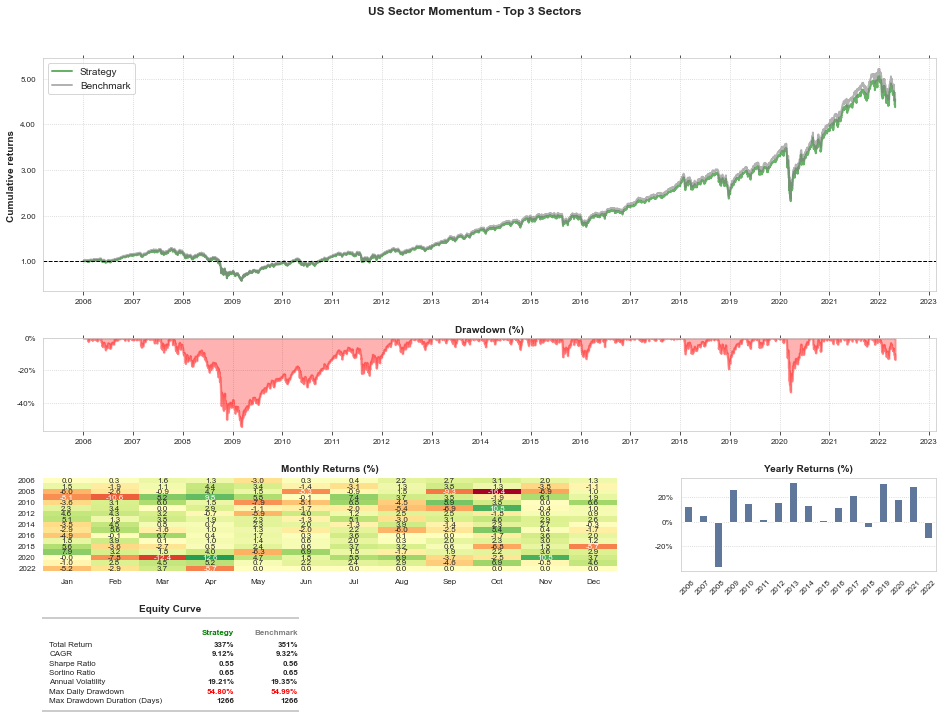

In [40]:
#tearsheet end results
tearsheet = TearsheetStatistics(
    strategy_equity=strategy_backtest.get_equity_curve(),
    benchmark_equity=benchmark_backtest.get_equity_curve(),
    title='US Sector Momentum - Top 3 Sectors'
)
tearsheet.plot_results()